# Assign B cell annotations

To assemble our annotations, we'll read our clustered B cell data and assign our expert annotations to those clusters. We'll then inspect the annotations in our UMAP projections, and output final labels for these cells.

For B cells, we have two groups of cells to label - Most of the B cells were assigned labels at one resolution, and the non-effector memory B cells were assigned labels after additional, iterative clustering. So, we'll load both of these sets, remove the memory cells from the rest of the B cells, assign identities based on clusters in each, and finally concatenate all of the cell barcodes.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc

### Helper function

This function makes it easy to pull csv files stored in HISE as a pandas data.frame

In [2]:
def read_csv_uuid(csv_uuid):
    csv_path = '/home/jupyter/cache/{u}'.format(u = csv_uuid)
    if not os.path.isdir(csv_path):
        hise_res = hisepy.reader.cache_files([csv_uuid])
    csv_filename = os.listdir(csv_path)[0]
    csv_file = '{p}/{f}'.format(p = csv_path, f = csv_filename)
    df = pd.read_csv(csv_file, index_col = 0)
    return df

## Read subclustering results from HISE

In [3]:
cell_class = 'b-cells'

In [4]:
h5ad_uuid = '99f83994-26ee-49af-a882-c1f2558daed2'
h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)

In [5]:
if not os.path.isdir(h5ad_path):
    hise_res = hisepy.reader.cache_files([h5ad_uuid])

In [6]:
h5ad_filename = os.listdir(h5ad_path)[0]
h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)

In [7]:
adata = sc.read_h5ad(h5ad_file)

In [8]:
adata.shape

(177994, 1209)

## Read memory cell subclustering results from HISE

In [9]:
mem_uuid = '51838754-b378-4f13-b447-82511bcd0a66'
mem_path = '/home/jupyter/cache/{u}'.format(u = mem_uuid)

In [10]:
if not os.path.isdir(mem_path):
    hise_res = hisepy.reader.cache_files([mem_path])

In [11]:
mem_filename = os.listdir(mem_path)[0]
mem_file = '{p}/{f}'.format(p = mem_path, f = mem_filename)

In [12]:
mem_adata = sc.read_h5ad(mem_file)

In [13]:
mem_adata

AnnData object with n_obs × n_vars = 47886 × 2110
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'celltypist.low', 'seurat.l1', 'seurat.l1.score', 'seurat.l2', 'seurat.l2.score', 'seurat.l2.5', 'seurat.l2.5.score', 'seurat.l3', 'seurat.l3.score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden', 'leiden_resolution_1', 'leiden_resol

## Subset non-memory cells

In [14]:
drop_lgl = [not x for x in adata.obs['barcodes'].isin(mem_adata.obs['barcodes'])]

In [15]:
nonmem_adata = adata[drop_lgl].copy()

In [16]:
nonmem_adata.shape

(130108, 1209)

## Read non-memory annotations

In [17]:
anno_uuid = '64930694-bbb2-49ff-baad-59b11d95eaf6'

In [18]:
anno = read_csv_uuid(anno_uuid)

## Assign non-memory labels

In [19]:
join_col = 'ms_leiden_2'

In [20]:
anno[join_col] = anno[join_col].astype('string').astype('category')

In [21]:
obs = nonmem_adata.obs

In [22]:
sum(obs[join_col].isin(anno[join_col]))

130108

In [23]:
nonmem_anno = obs.merge(anno, how = 'left', on = join_col)

In [24]:
nonmem_anno.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,log1p_total_counts_mito,pct_counts_mito,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,ms_leiden_2,AIFI_L3,AIFI_L1,AIFI_L2
0,cf72a14a48b611ea8957bafe6d70929e,B001,bestial_fireless_rottweiler,cf72a14a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,904,58,10269,...,4.077537,1.968103,7,7,14,18,21,T_B doublet,T_B doublet,T_B doublet
1,cf73500e48b611ea8957bafe6d70929e,B001,stressed_wishful_flea,cf73500e48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1085,71,12422,...,4.276666,1.978267,7,1,1,0,0,Core naive B cell,B cell,Naive B cell
2,cf73694a48b611ea8957bafe6d70929e,B001,silicone_nonsolar_snowgeese,cf73694a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1152,198,11355,...,5.293305,5.899881,10,5,9,11,11,CD27+ effector B cell,B cell,Effector B cell
3,cf73fbee48b611ea8957bafe6d70929e,B001,luxuriant_overrated_gypsymoth,cf73fbee48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1769,245,18105,...,5.505332,4.552211,7,4,3,6,1,Transitional B cell,B cell,Transitional B cell
4,cf74ae2c48b611ea8957bafe6d70929e,B001,real_bighearted_kitty,cf74ae2c48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,692,83,5468,...,4.430817,4.976019,7,1,1,0,0,Core naive B cell,B cell,Naive B cell


## Read memory annotations

In [25]:
mem_anno_uuid = 'c77dfb1e-453a-4ea1-b6ec-d3b1e43437cd'
mem_anno = read_csv_uuid(mem_anno_uuid)

## Assign memory labels

In [26]:
join_col = 'ms_leiden_2.5'

In [27]:
mem_anno[join_col] = mem_anno[join_col].astype('string').astype('category')

In [28]:
obs = mem_adata.obs

In [29]:
sum(obs[join_col].isin(mem_anno[join_col]))

47886

In [30]:
mem_anno = obs.merge(mem_anno, how = 'left', on = join_col)

In [31]:
mem_anno.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,ms_leiden_2,umap_1,umap_2,ms_leiden_2.5,AIFI_L3,AIFI_L1,AIFI_L2
0,cf720af048b611ea8957bafe6d70929e,B001,patterny_untalented_halcyon,cf720af048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,928,66,7856,...,2,4,2,2,NaN,NaN,8,Core memory B cell,B cell,Memory B cell
1,cf78473048b611ea8957bafe6d70929e,B001,burly_backward_tuatara,cf78473048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1372,338,17586,...,3,6,13,13,NaN,NaN,5,Core memory B cell,B cell,Memory B cell
2,cf79279a48b611ea8957bafe6d70929e,B001,illadvised_applicable_annelid,cf79279a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,757,207,8651,...,3,7,10,13,NaN,NaN,8,Core memory B cell,B cell,Memory B cell
3,cf80e44e48b611ea8957bafe6d70929e,B001,frousy_vapourific_oropendola,cf80e44e48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,776,70,5600,...,2,4,2,2,NaN,NaN,8,Core memory B cell,B cell,Memory B cell
4,cf81a58c48b611ea8957bafe6d70929e,B001,minor_clerkish_hartebeest,cf81a58c48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1244,151,10561,...,2,5,4,2,NaN,NaN,9,Early memory B cell,B cell,Memory B cell


## Concatenate annotations

In [32]:
anno = pd.concat([nonmem_anno, mem_anno], axis = 0)

In [33]:
anno = anno[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

## Add to AnnData to preview assignments

In [34]:
anno = anno.set_index('barcodes')

In [35]:
obs = adata.obs
obs = obs.merge(anno, how = 'left', left_index = True, right_index = True)

In [36]:
adata.obs = obs

In [37]:
adata.obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,log1p_total_counts_mito,pct_counts_mito,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,ms_leiden_2,AIFI_L1,AIFI_L2,AIFI_L3
barcodes,,,,,,,,,,,,,,,,,,,,,
cf720af048b611ea8957bafe6d70929e,cf720af048b611ea8957bafe6d70929e,B001,patterny_untalented_halcyon,cf720af048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,928,66,7856,...,4.204693,2.798982,10,2,4,2,2,B cell,Memory B cell,Core memory B cell
cf72a14a48b611ea8957bafe6d70929e,cf72a14a48b611ea8957bafe6d70929e,B001,bestial_fireless_rottweiler,cf72a14a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,904,58,10269,...,4.077537,1.968103,7,7,14,18,21,T_B doublet,T_B doublet,T_B doublet
cf73500e48b611ea8957bafe6d70929e,cf73500e48b611ea8957bafe6d70929e,B001,stressed_wishful_flea,cf73500e48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1085,71,12422,...,4.276666,1.978267,7,1,1,0,0,B cell,Naive B cell,Core naive B cell
cf73694a48b611ea8957bafe6d70929e,cf73694a48b611ea8957bafe6d70929e,B001,silicone_nonsolar_snowgeese,cf73694a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1152,198,11355,...,5.293305,5.899881,10,5,9,11,11,B cell,Effector B cell,CD27+ effector B cell
cf73fbee48b611ea8957bafe6d70929e,cf73fbee48b611ea8957bafe6d70929e,B001,luxuriant_overrated_gypsymoth,cf73fbee48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1769,245,18105,...,5.505332,4.552211,7,4,3,6,1,B cell,Transitional B cell,Transitional B cell


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


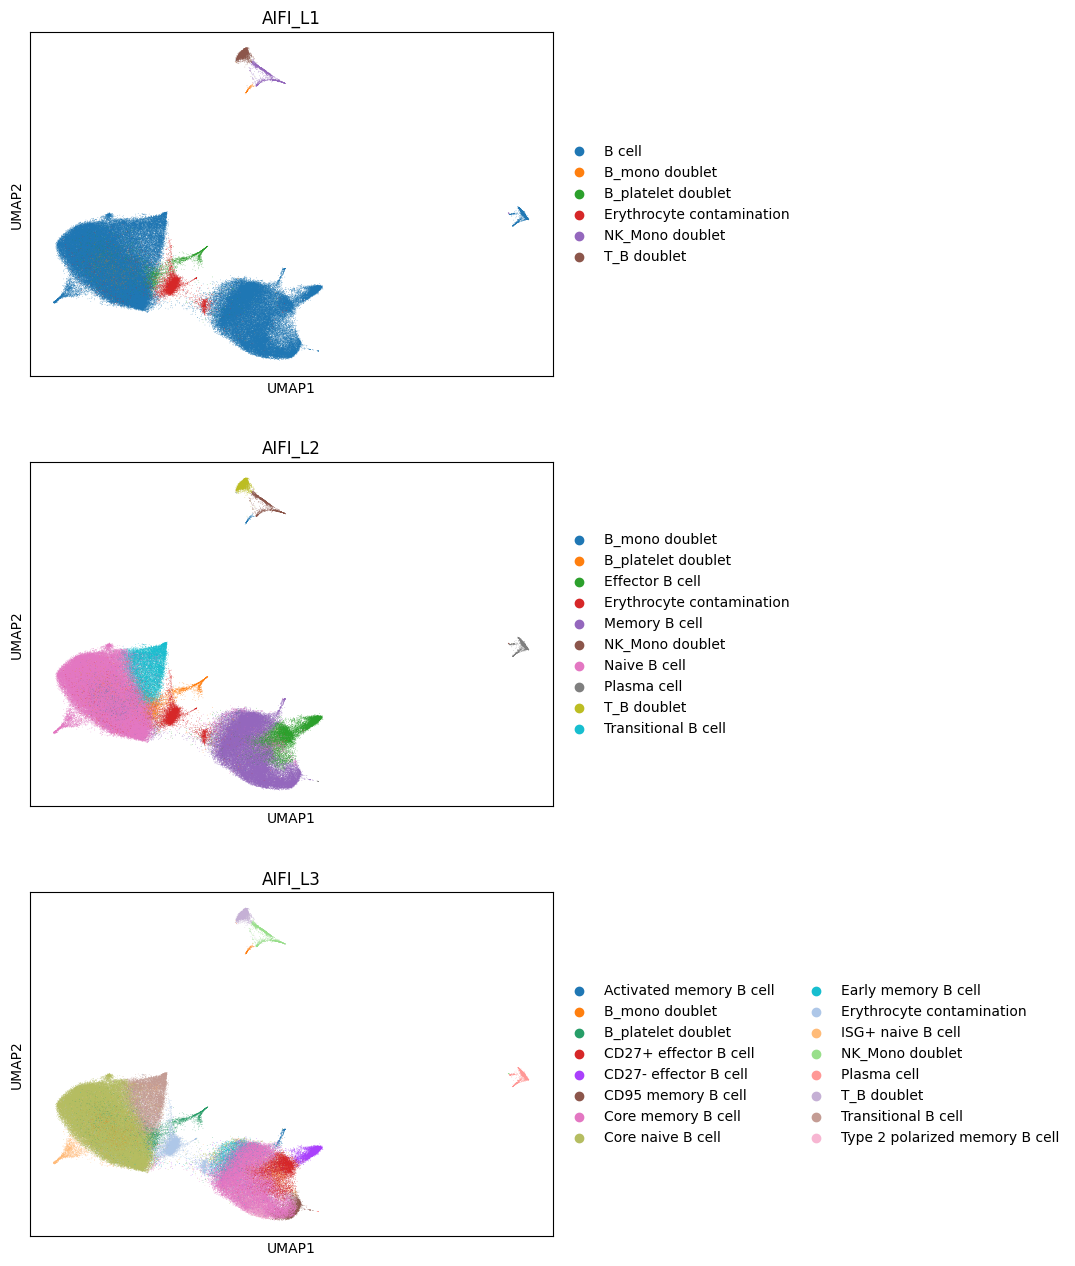

In [38]:
sc.pl.umap(adata, color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'], ncols = 1)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


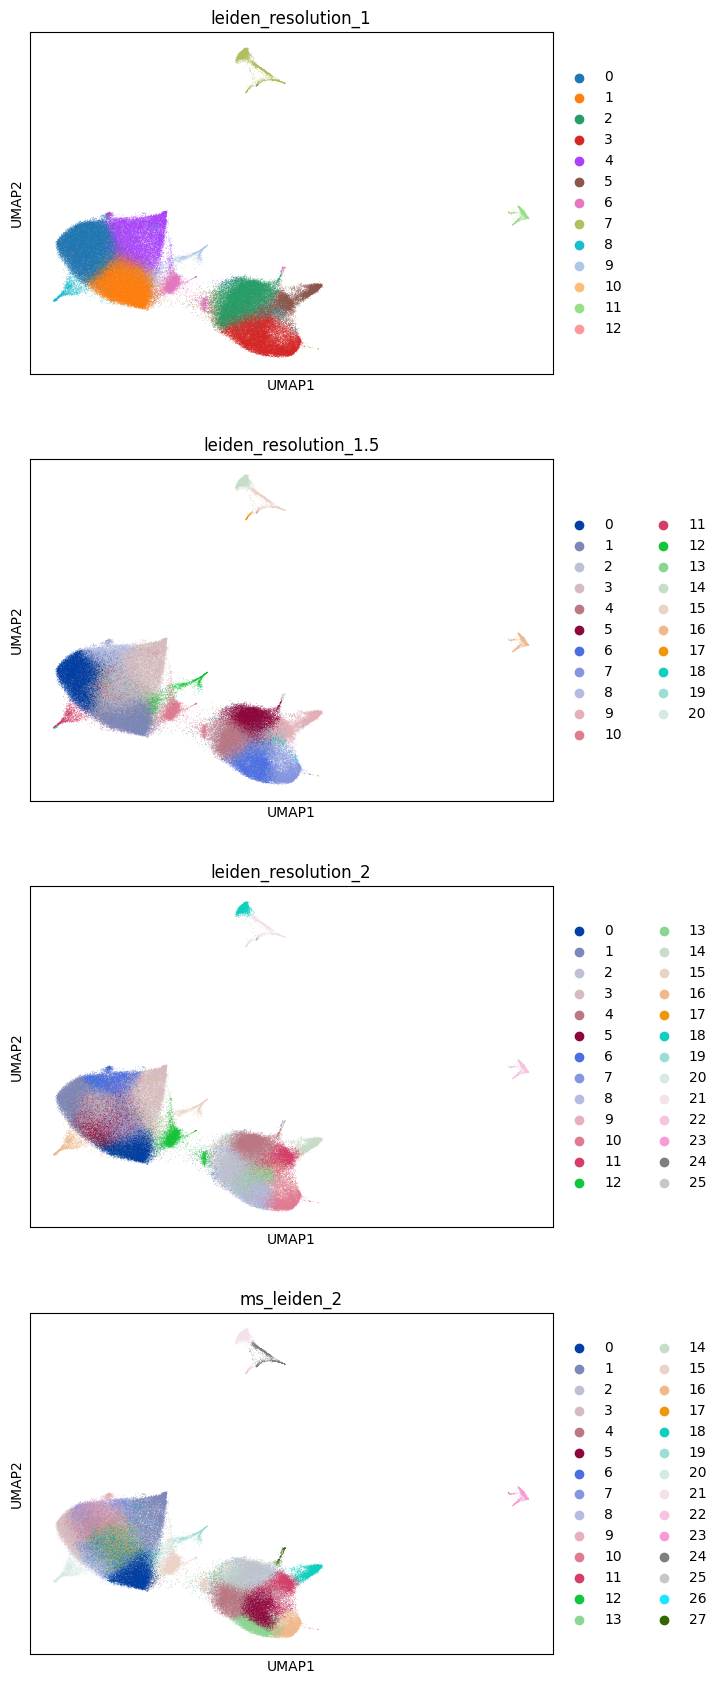

In [39]:
sc.pl.umap(adata, 
           color = ['leiden_resolution_1',
                    'leiden_resolution_1.5',
                    'leiden_resolution_2',
                    'ms_leiden_2'],
           ncols = 1)

## Output final annotations

In [40]:
obs = adata.obs
obs = obs.reset_index(drop = True)

In [41]:
umap_mat = adata.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [42]:
obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,ms_leiden_2,AIFI_L1,AIFI_L2,AIFI_L3,umap_1,umap_2
0,cf720af048b611ea8957bafe6d70929e,B001,patterny_untalented_halcyon,cf720af048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,928,66,7856,...,10,2,4,2,2,B cell,Memory B cell,Core memory B cell,1.259842,-1.832500
1,cf72a14a48b611ea8957bafe6d70929e,B001,bestial_fireless_rottweiler,cf72a14a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,904,58,10269,...,7,7,14,18,21,T_B doublet,T_B doublet,T_B doublet,1.463564,11.663149
2,cf73500e48b611ea8957bafe6d70929e,B001,stressed_wishful_flea,cf73500e48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1085,71,12422,...,7,1,1,0,0,B cell,Naive B cell,Core naive B cell,-2.856547,-0.907700
3,cf73694a48b611ea8957bafe6d70929e,B001,silicone_nonsolar_snowgeese,cf73694a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1152,198,11355,...,10,5,9,11,11,B cell,Effector B cell,CD27+ effector B cell,3.092754,-1.697405
4,cf73fbee48b611ea8957bafe6d70929e,B001,luxuriant_overrated_gypsymoth,cf73fbee48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1769,245,18105,...,7,4,3,6,1,B cell,Transitional B cell,Transitional B cell,-3.169807,2.543742


In [43]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [44]:
obs_out_csv = '{p}/ref_pbmc_{c}_labeled_meta_umap_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_csv(obs_out_csv, index = False)

In [45]:
obs_out_parquet = '{p}/ref_pbmc_{c}_labeled_meta_umap_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)

In [46]:
bc_anno = obs[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

In [47]:
label_out_csv = '{p}/ref_pbmc_{c}_barcode_labels_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
bc_anno.to_csv(label_out_csv, index = False)

In [48]:
label_out_parquet = '{p}/ref_pbmc_{c}_barcode_labels_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
bc_anno.to_parquet(label_out_parquet, index = False)

## Upload annotations to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [49]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'B cell barcode annotations {d}'.format(d = date.today())

In [50]:
in_files = [h5ad_uuid, mem_uuid, anno_uuid, mem_anno_uuid]

In [51]:
in_files

['99f83994-26ee-49af-a882-c1f2558daed2',
 '51838754-b378-4f13-b447-82511bcd0a66',
 '64930694-bbb2-49ff-baad-59b11d95eaf6',
 'c77dfb1e-453a-4ea1-b6ec-d3b1e43437cd']

In [52]:
out_files = [obs_out_csv, obs_out_parquet,
             label_out_csv, label_out_parquet]

In [53]:
out_files

['output/ref_pbmc_b-cells_labeled_meta_umap_2024-02-29.csv',
 'output/ref_pbmc_b-cells_labeled_meta_umap_2024-02-29.parquet',
 'output/ref_pbmc_b-cells_barcode_labels_2024-02-29.csv',
 'output/ref_pbmc_b-cells_barcode_labels_2024-02-29.parquet']

In [54]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

you are trying to upload file_ids... ['output/ref_pbmc_b-cells_labeled_meta_umap_2024-02-29.csv', 'output/ref_pbmc_b-cells_labeled_meta_umap_2024-02-29.parquet', 'output/ref_pbmc_b-cells_barcode_labels_2024-02-29.csv', 'output/ref_pbmc_b-cells_barcode_labels_2024-02-29.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': '88a54a19-2cd1-404c-8175-48ea5f8f3c8c',
 'files': ['output/ref_pbmc_b-cells_labeled_meta_umap_2024-02-29.csv',
  'output/ref_pbmc_b-cells_labeled_meta_umap_2024-02-29.parquet',
  'output/ref_pbmc_b-cells_barcode_labels_2024-02-29.csv',
  'output/ref_pbmc_b-cells_barcode_labels_2024-02-29.parquet']}

In [55]:
import session_info
session_info.show()